# Clustering FTIR Scanners based on claibration Dataset

## Introduction:

In this Note book we aim to Find a way to cluster 8 FTIR scanners depending on their  response upon a calibration dataset of contains sample measured on all 8 devices.
The approach in this notebook is to use the reponse of each device to the calibration sample to extract features of the device that can help us categorize this device

## Theory:

As we said we need some features to cluster these devices.
We can assume that an insightful feature of the device that can help us distinguishing it from the others is simply a metric that could tell us how similar or disimilar this device relative to the other .


So, we will try to calculate some metrics that could be insightful of how each device is similar to other devices.

We will calculate Two seperate metrics and use them both as feature of our scanner

### Average Eucledian Distance:

The average Eucledian distance is the equavelant of pythagoras distance but in more than 2 dimensions:

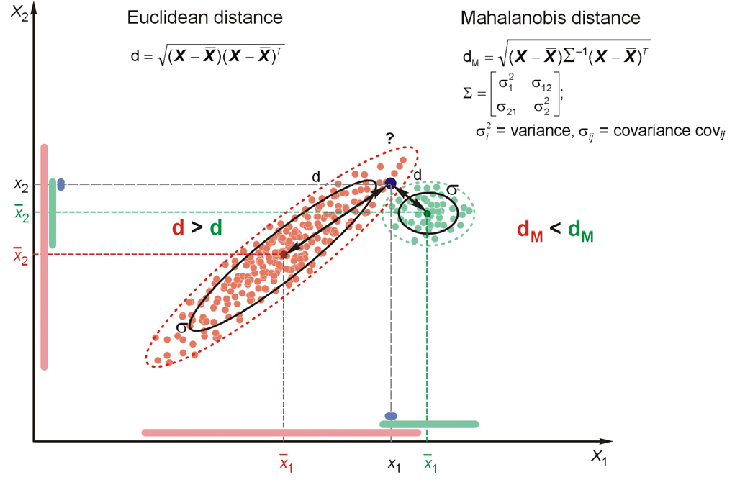 

For each Device we will calculate the average Eucledian Distance between it and all the other devices across all samples.


### Average Cosine Distance:

This approach measures the average  cosine similarity (angular distance) between two devices across all samples

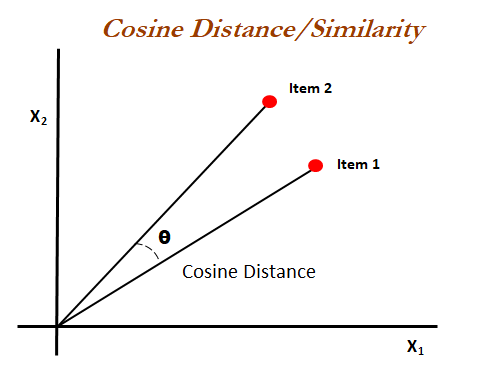

## Implementation:

First We need to import our packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy.spatial.distance import euclidean,cosine
from scipy import signal
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]

Then we will read our datasets of each scanner from CSV files

First we need to make sure that all of the spectra are in the absorbance form ,
so we convert the spectra that are in the reflectance form to the absorbance form:

To convert We use the formula :Absorbance =  2-log10(Reflectance) 

In [2]:
my_path = 'Absorbance form/'
my_path2 = 'Reflectance form/'

df_52 = pd.read_csv(my_path2+'scanner_52.csv')
df_171 = pd.read_csv(my_path2+'scanner171.csv')

for i in range(30):
    df_171.iloc[i] = 2-np.log10(df_171.iloc[i])
    df_52.iloc[i] = 2-np.log10(df_52.iloc[i])
    

Then we will read the rest of the files without conversion because the are already in the absorbance form

In [3]:
df_122 = pd.read_csv(my_path+'122_spectrum.csv')
df_169 = pd.read_csv(my_path+'169_spectrum.csv')
df_190 = pd.read_csv(my_path+'190_spectrum.csv')
df_10119 = pd.read_csv(my_path+'10119_spectrum.csv')
df_10121 = pd.read_csv(my_path+'10121_spectrum.csv')
df_211100001 = pd.read_csv(my_path+'211100001_spectrum.csv')
# there was a problem in the keys of the device 169 as they were not equal to the rest of column names due to rounding error 
# so I fixed that error with the following Line
df_169 = pd.DataFrame(df_169.to_numpy(),columns=df_122.keys())

Now We will print some info about the data frames to get an insight of the data

In [4]:
df_52.head()

,3921.568654,3935.185205,3948.801756,3962.418307,3976.034857,3989.651408,4003.267959,4016.884509,4030.50106,4044.117611,...,7284.856681,7298.473231,7312.089782,7325.706333,7339.322884,7352.939434,7366.555985,7380.172536,7393.789086,7407.405637
0,0.559955,0.572687,0.584987,0.596320,0.606629,0.616297,0.625783,0.635000,0.642807,0.646931,...,0.153694,0.154630,0.150994,0.143075,0.133128,0.123763,0.116628,0.111852,0.108364,0.104766
1,0.465879,0.474068,0.481795,0.489209,0.496969,0.506115,0.517631,0.531721,0.547072,0.560544,...,0.195049,0.197223,0.193727,0.184755,0.173011,0.161722,0.152961,0.147012,0.142785,0.138813
2,0.652061,0.666571,0.680367,0.692731,0.703478,0.712782,0.720804,0.727227,0.730965,0.730314,...,0.194990,0.193524,0.189209,0.182064,0.173283,0.164434,0.156681,0.150389,0.145208,0.140489
3,0.697644,0.711909,0.725419,0.737518,0.748086,0.757374,0.765595,0.772437,0.776753,0.776712,...,0.223218,0.220355,0.214972,0.206997,0.197286,0.187011,0.177102,0.168006,0.159795,0.152432
4,0.539026,0.552614,0.565611,0.577367,0.587643,0.596419,0.603634,0.608850,0.611086,0.608982,...,0.135796,0.135767,0.133592,0.129347,0.124015,0.118804,0.114527,0.111306,0.108670,0.105957


In [5]:
df_52.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Columns: 257 entries, 3921.568654 to 7407.405637
dtypes: float64(257)
memory usage: 60.4 KB


So the data of each device have wavenumbers  3921.568654 to 7407.405637

In [6]:
df_52.describe()

,3921.568654,3935.185205,3948.801756,3962.418307,3976.034857,3989.651408,4003.267959,4016.884509,4030.50106,4044.117611,...,7284.856681,7298.473231,7312.089782,7325.706333,7339.322884,7352.939434,7366.555985,7380.172536,7393.789086,7407.405637
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.535277,0.546889,0.558117,0.568461,0.577798,0.586406,0.594675,0.602619,0.609382,0.613090,...,0.174208,0.174466,0.170766,0.163316,0.153986,0.145004,0.137803,0.132576,0.128551,0.124686
std,0.101095,0.102165,0.103172,0.104114,0.104979,0.105652,0.105912,0.105507,0.104319,0.102504,...,0.054066,0.052465,0.050974,0.049427,0.047600,0.045292,0.042473,0.039397,0.036549,0.034423
min,0.241635,0.250093,0.258091,0.265233,0.271683,0.278430,0.286843,0.297833,0.310839,0.323173,...,0.065945,0.071358,0.071100,0.065648,0.058173,0.052299,0.050090,0.051312,0.053938,0.055431
25%,0.462937,0.473330,0.484410,0.495167,0.504948,0.512974,0.519138,0.526814,0.534863,0.542361,...,0.132051,0.133607,0.131463,0.125375,0.117289,0.110284,0.105679,0.102682,0.100208,0.097391
50%,0.541352,0.554492,0.567162,0.578608,0.588461,0.596672,0.603315,0.608219,0.610671,0.609399,...,0.171846,0.170326,0.166313,0.160064,0.151079,0.142415,0.135835,0.131304,0.127555,0.123042
75%,0.619283,0.629061,0.638598,0.647688,0.656485,0.665501,0.675282,0.685868,0.696245,0.703784,...,0.222829,0.219646,0.214333,0.206825,0.198857,0.190721,0.182572,0.173837,0.165278,0.158278
max,0.697644,0.711909,0.725419,0.737518,0.748086,0.757374,0.765595,0.772437,0.776753,0.776712,...,0.273070,0.272091,0.265621,0.253584,0.238098,0.221981,0.207370,0.195158,0.189925,0.187121


Next we will plot a certain sample measured by all devices to see the small shifts in peaks 

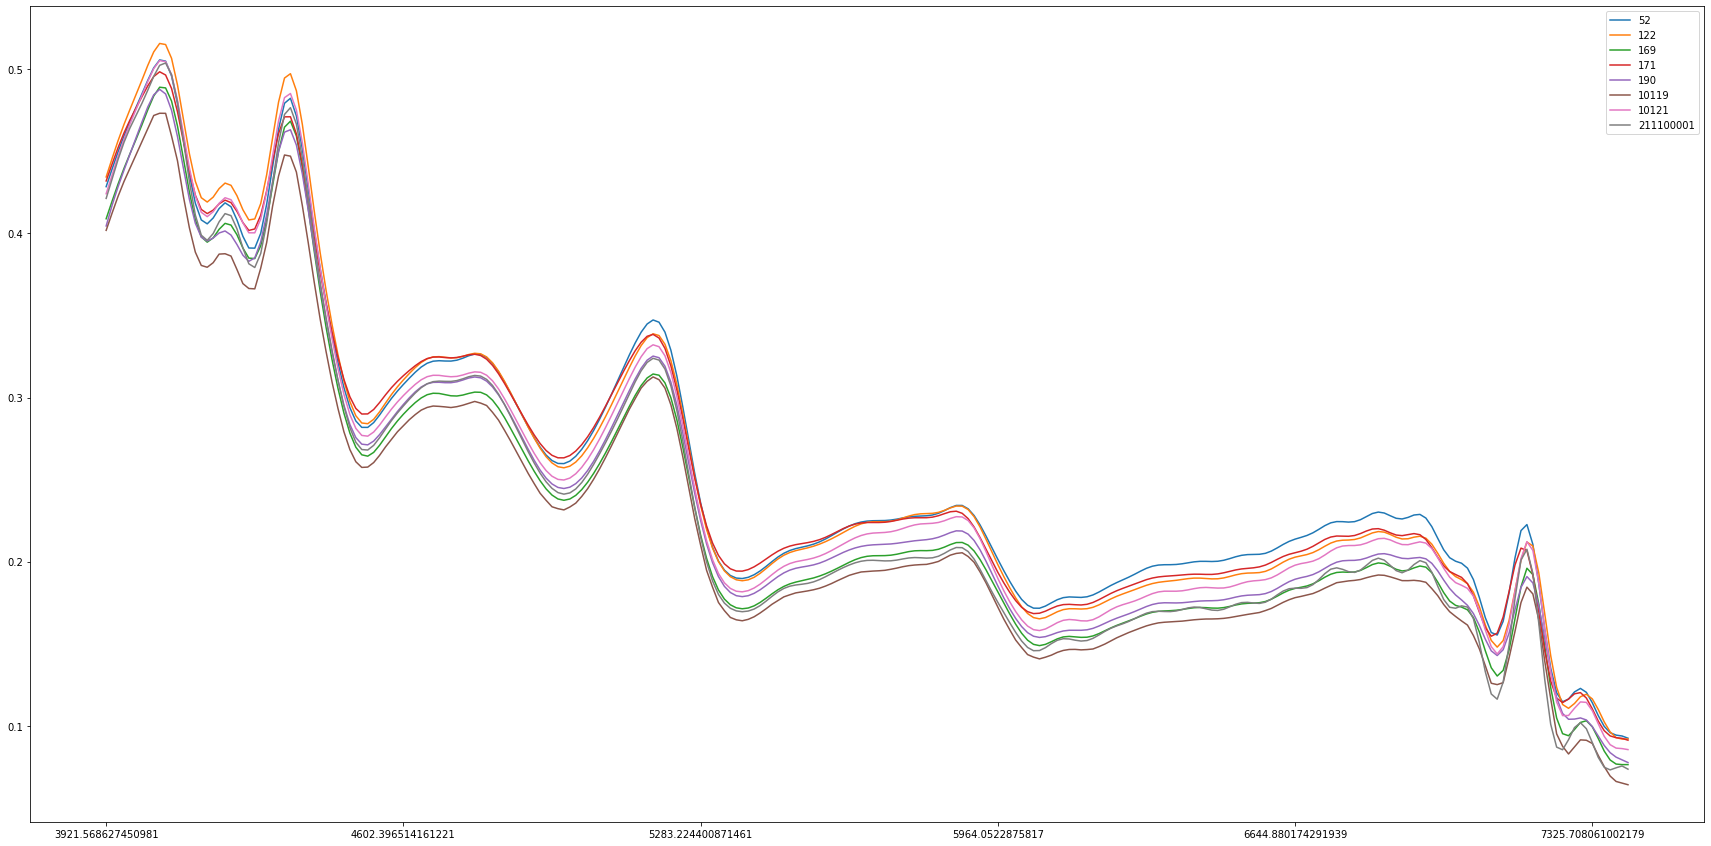

In [7]:
index = 12 # the sample number from 0 to 29
df_52.iloc[index].plot(label='52')
df_122.iloc[index].plot(label='122')
df_169.iloc[index].plot(label='169')
df_171.iloc[index].plot(label='171')
df_190.iloc[index].plot(label='190')
df_10119.iloc[index].plot(label='10119')
df_10121.iloc[index].plot(label='10121')
df_211100001.iloc[index].plot(label='211100001')

plt.legend() #give each device a different color

As we can see, its already obvious that there are some devices similar to each other than the rest of the devices

Now we will compute both:

  1- Average Eucledian Distance between each two devices.
  
  2- Average Cosine Distance between each two devices.
  
across all samples 

The following code will produce two dictionaries each of them is indexed by the scanner names:

1- euc_dist: which will contain the eucledian distance between the each sacnner an all the other scanners including it self

2- cos_dist: which will contain the cosine distance between the each sacnner an all the other scanners including it self


In [20]:
scanner_names = ['52','122','169','171','190','10119','10121','211100001']
scanners = {'52':df_52,
            '122':df_122,
            '169':df_169,
            '171':df_171,
            '190':df_190,
            '10119':df_10119,
            '10121':df_10121,
            '211100001':df_211100001}
euc_dist = {'52':None,
            '122':None,
            '169':None,
            '171':None,
            '190':None,
            '10119':None,
            '10121':None,
            '211100001':None}

cos_dist = {'52':None,
            '122':None,
            '169':None,
            '171':None,
            '190':None,
            '10119':None,
            '10121':None,
            '211100001':None}


for scanner1 in scanners:
    euc = []
    cos = []
    for scanner2 in scanners:
        mean_dist = 0
        mean_cos = 0
        for i in range(30):
            mean_dist += (1- euclidean(scanners[scanner1].iloc[i],scanners[scanner2].iloc[i]))
            mean_cos += 1- cosine(scanners[scanner1].iloc[i],scanners[scanner2].iloc[i])
        mean_dist/=30
        mean_cos/=30
        euc.append(mean_dist)
        cos.append(mean_cos)
    euc_dist[scanner1] = euc
    cos_dist[scanner1] = cos

Now  We will Generate a full report concerning a certain scanner as it will sort all the other scanners from the nearst to the furthest in both the eucledian and cosine metric indicating the value of eucledian and cosine distance of each of them 

In [21]:
subject = '52' # the name of the scanner  in the question

idx = sorted(range(len(euc_dist[subject])), key=lambda k: euc_dist[subject][k],reverse=True)
print('Final Report :')
print('=====================================================================================')



print('Scanners sorted upon their average Eucledian similarity from the subject:',subject)

for i in idx:
    print('Scanner:',scanner_names[i],'-> Eucledian similarity:',euc_dist[subject][i])
    
print('--------------------------------------------------------------------------------------')
print('Scanners sorted upon their average cosine similarity from the subject:',subject)
idx = sorted(range(len(cos_dist[subject])), key=lambda k: cos_dist[subject][k],reverse=True)
for i in idx:
    print('Scanner:',scanner_names[i],'-> Cosine similarity:',cos_dist[subject][i])

Final Report :
Scanners sorted upon their average Eucledian similarity from the subject: 52
Scanner: 52 -> Eucledian similarity: 1.0
Scanner: 171 -> Eucledian similarity: 0.7747868652024411
Scanner: 10121 -> Eucledian similarity: 0.7688657272334449
Scanner: 169 -> Eucledian similarity: 0.7635686466940368
Scanner: 122 -> Eucledian similarity: 0.7578962768164512
Scanner: 190 -> Eucledian similarity: 0.6971357964597205
Scanner: 10119 -> Eucledian similarity: 0.5480256621312092
Scanner: 211100001 -> Eucledian similarity: 0.542489118472634
--------------------------------------------------------------------------------------
Scanners sorted upon their average cosine similarity from the subject: 52
Scanner: 52 -> Cosine similarity: 1.0
Scanner: 10121 -> Cosine similarity: 0.9996175753803589
Scanner: 122 -> Cosine similarity: 0.9996120983194515
Scanner: 171 -> Cosine similarity: 0.999533145935395
Scanner: 169 -> Cosine similarity: 0.999483973163813
Scanner: 190 -> Cosine similarity: 0.9994357

Its obvious that the cosine similarity between all the scanners is almost 1 so we will disregard the cosine similarity 

### Heatmap :

In [22]:
euc_matrix = pd.DataFrame(euc_dist,index=scanner_names)
euc_matrix

,52,122,169,171,190,10119,10121,211100001
52,1.000000,0.757896,0.763569,0.774787,0.697136,0.548026,0.768866,0.542489
122,0.757896,1.000000,0.793340,0.710542,0.639788,0.481196,0.709914,0.491856
169,0.763569,0.793340,1.000000,0.751129,0.726810,0.609928,0.805981,0.612876
171,0.774787,0.710542,0.751129,1.000000,0.724408,0.614714,0.766539,0.583705
190,0.697136,0.639788,0.726810,0.724408,1.000000,0.677840,0.747135,0.746832
10119,0.548026,0.481196,0.609928,0.614714,0.677840,1.000000,0.661514,0.666358
10121,0.768866,0.709914,0.805981,0.766539,0.747135,0.661514,1.000000,0.650625
211100001,0.542489,0.491856,0.612876,0.583705,0.746832,0.666358,0.650625,1.000000


[Text(0.5, 0, '52'),
 Text(1.5, 0, '122'),
 Text(2.5, 0, '169'),
 Text(3.5, 0, '171'),
 Text(4.5, 0, '190'),
 Text(5.5, 0, '10119'),
 Text(6.5, 0, '10121'),
 Text(7.5, 0, '211100001')]

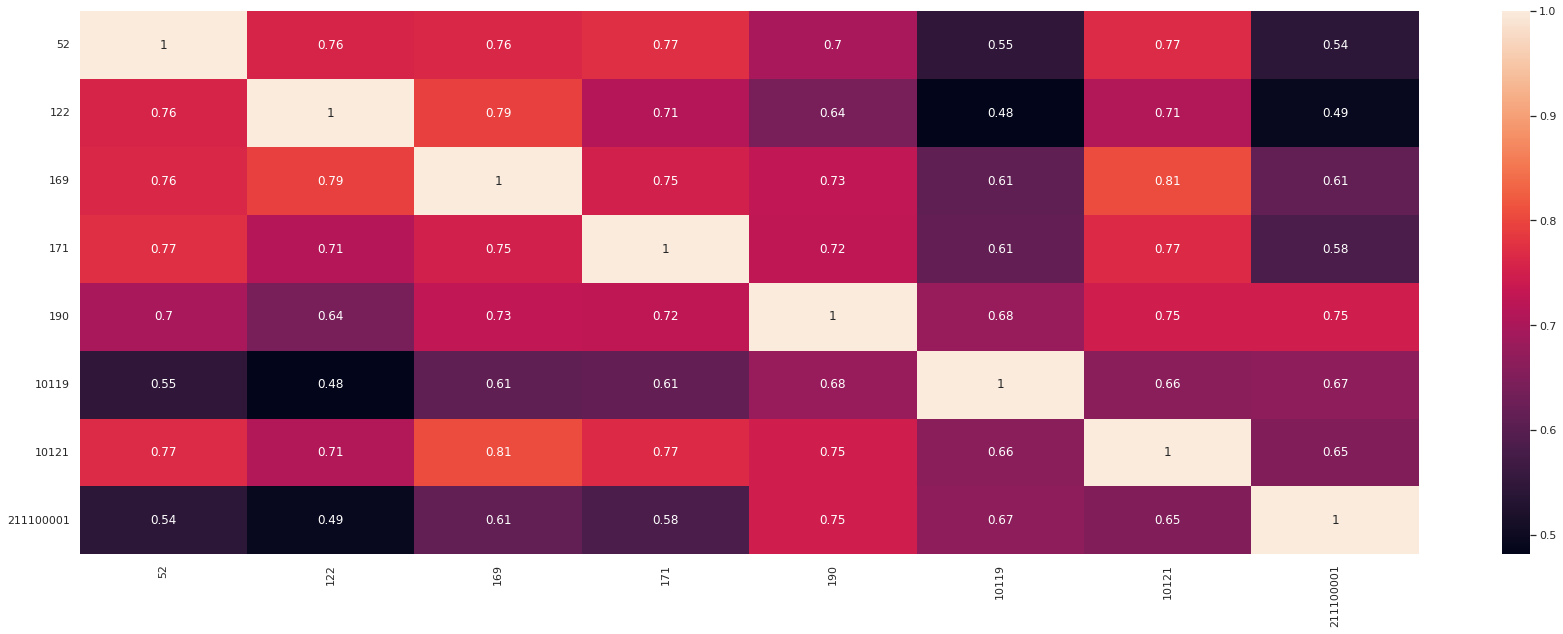

In [23]:
sns.set_theme()
ax = sns.heatmap(euc_matrix,annot=True)
ax.set_yticklabels(ax.get_yticklabels(),rotation = -0)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)